In [45]:
import numpy as np
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve
)
from sklearn.model_selection import GridSearchCV
import gzip
import joblib
import os
import json
from sklearn.metrics import precision_score, recall_score, f1_score, balanced_accuracy_score

In [27]:
test = pd.read_csv('../files/input/test_data.csv.zip')
train = pd.read_csv('../files/input/train_data.csv.zip')

In [30]:
test.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
1,20000,1,3,2,35,-2,-2,-2,-2,-1,...,0,13007,13912,0,0,0,13007,1122,0,0
2,200000,2,3,2,34,0,0,2,0,0,...,2513,1828,3731,2306,12,50,300,3738,66,0
3,250000,1,1,2,29,0,0,0,0,0,...,59696,56875,55512,3000,3000,3000,3000,3000,3000,0
4,50000,2,3,3,23,1,2,0,0,0,...,28771,29531,30211,0,1500,1100,1200,1300,1100,0


In [29]:
#renombre de la columna target
train.rename(columns={'default payment next month': 'default'}, inplace=True)
test.rename(columns={'default payment next month': 'default'}, inplace=True)

#eliminar columna ID
train.drop(columns=['ID'], inplace=True)
test.drop(columns=['ID'], inplace=True)

#depurado de datos faltantes
train.dropna(inplace=True)
test.dropna(inplace=True)

#agrupado de categorias en la columna education
train.loc[train['EDUCATION'] > 4, 'EDUCATION'] = 4
test.loc[test['EDUCATION'] > 4, 'EDUCATION'] = 4


In [31]:
# separar datasets en features y target
X_train = train.drop(columns=['default'])
y_train = train['default']
X_test = test.drop(columns=['default'])
y_test = test['default']

In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

#identificar variables categóricas
cat_features = X_train.select_dtypes(include=['object', 'category']).columns
num_features = X_train.select_dtypes(exclude=['object', 'category']).columns

#transformador para variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features),
        ('num', 'passthrough', num_features)
    ]
)

In [33]:
#maqueta de modelo
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

#pipeline
modelo = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf)
])

#entrenamiento del modelo
modelo.fit(X_train, y_train)

#predicción del modelo
y_pred = modelo.predict(X_test)

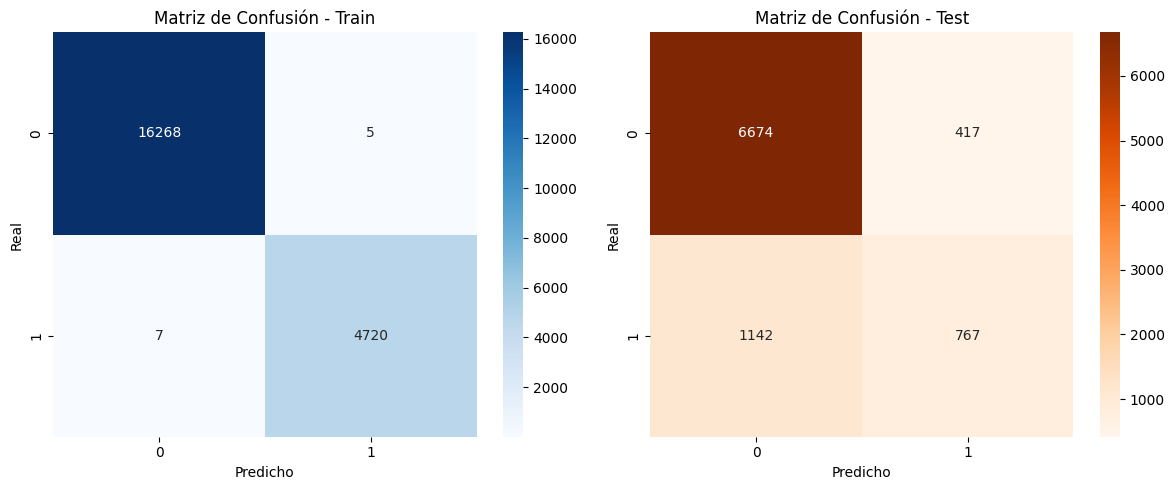

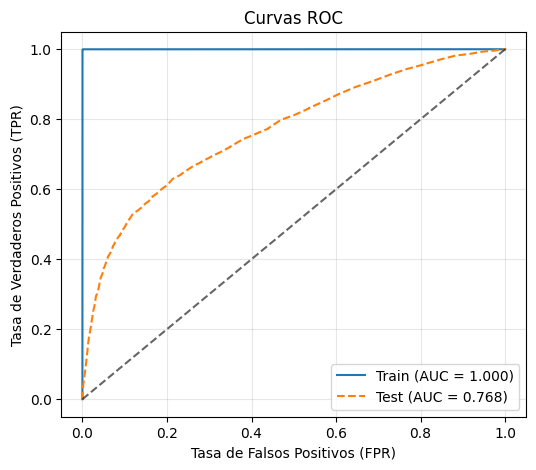

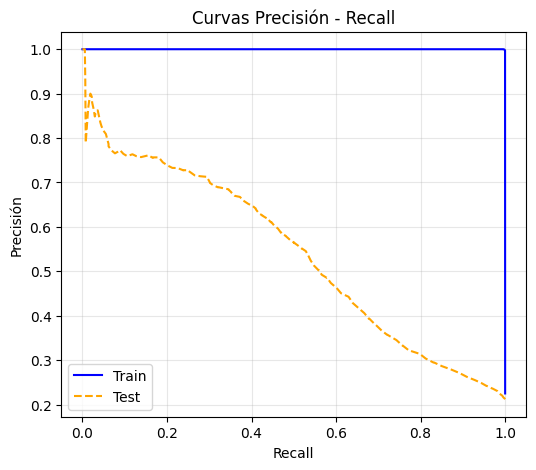

=== Clasificación - Train ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16273
           1       1.00      1.00      1.00      4727

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000

=== Clasificación - Test ===
              precision    recall  f1-score   support

           0       0.85      0.94      0.90      7091
           1       0.65      0.40      0.50      1909

    accuracy                           0.83      9000
   macro avg       0.75      0.67      0.70      9000
weighted avg       0.81      0.83      0.81      9000



In [37]:
# Predicciones
y_train_pred = modelo.predict(X_train)
y_test_pred = modelo.predict(X_test)

# Probabilidades (para curvas ROC y PR)
y_train_proba = modelo.predict_proba(X_train)[:, 1]
y_test_proba = modelo.predict_proba(X_test)[:, 1]

# --- 3️⃣ Matrices de confusión ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Matriz de Confusión - Train')
axes[0].set_xlabel('Predicho')
axes[0].set_ylabel('Real')

sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, fmt='d', cmap='Oranges', ax=axes[1])
axes[1].set_title('Matriz de Confusión - Test')
axes[1].set_xlabel('Predicho')
axes[1].set_ylabel('Real')

plt.tight_layout()
plt.show()

# --- 4️⃣ Curvas ROC ---
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(fpr_train, tpr_train, label=f'Train (AUC = {roc_auc_score(y_train, y_train_proba):.3f})')
plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {roc_auc_score(y_test, y_test_proba):.3f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.title('Curvas ROC')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- 5️⃣ Curvas Precision-Recall ---
prec_train, rec_train, _ = precision_recall_curve(y_train, y_train_proba)
prec_test, rec_test, _ = precision_recall_curve(y_test, y_test_proba)

plt.figure(figsize=(6, 5))
plt.plot(rec_train, prec_train, label='Train', color='blue')
plt.plot(rec_test, prec_test, label='Test', color='orange', linestyle='--')
plt.title('Curvas Precisión - Recall')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- 6️⃣ Reporte de métricas ---
print("=== Clasificación - Train ===")
print(classification_report(y_train, y_train_pred))
print("=== Clasificación - Test ===")
print(classification_report(y_test, y_test_pred))

In [39]:
# Definir la rejilla de hiperparámetros del Random Forest
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Configurar la búsqueda con validación cruzada
grid_search = GridSearchCV(
    estimator=modelo,
    param_grid=param_grid,
    scoring='balanced_accuracy',   
    cv=10,                         
    n_jobs=-1,                     
    verbose=2                      
)

# Ejecutar la optimización
grid_search.fit(X_train, y_train)

# Ver los mejores resultados
print("🔹 Mejor puntaje (balanced accuracy):", grid_search.best_score_)
print("🔹 Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Guardar el mejor modelo
best_model = grid_search.best_estimator_


Fitting 10 folds for each of 108 candidates, totalling 1080 fits
🔹 Mejor puntaje (balanced accuracy): 0.6592027111748602
🔹 Mejores hiperparámetros encontrados:
{'classifier__max_depth': 30, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [42]:
# Asegurar ruta
os.makedirs("../files/models", exist_ok=True)
os.makedirs("../files/output", exist_ok=True)

# Definir la ruta del modelo comprimido
model_path = "../files/models/model.pkl.gz"

# Guardar el modelo usando gzip + joblib
with gzip.open(model_path, "wb") as f:
    joblib.dump(best_model, f)

print(f"✅ Modelo guardado correctamente en {os.path.abspath(model_path)}")

✅ Modelo guardado correctamente en c:\Descriptiva\LAB-01-prediccion-del-default-usando-rf-jurodriguezra-ops\files\models\model.pkl.gz


In [46]:
# Crear carpeta de salida si no existe
os.makedirs("../files/output", exist_ok=True)

# Predicciones
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calcular métricas
metrics = []

for dataset, y_true, y_pred in [
    ('train', y_train, y_train_pred),
    ('test', y_test, y_test_pred)
]:
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    
    metrics.append({
        'dataset': dataset,
        'precision': round(precision, 4),
        'balanced_accuracy': round(balanced_acc, 4),
        'recall': round(recall, 4),
        'f1_score': round(f1, 4)
    })

# Guardar métricas en JSON
metrics_path = "../files/output/metrics.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=4)

print(f"✅ Métricas guardadas en {metrics_path}")

✅ Métricas guardadas en ../files/output/metrics.json


In [47]:
# Cargar lo que ya teníamos en metrics.json
with open(metrics_path, "r") as f:
    metrics_data = json.load(f)

for dataset, y_true, y_pred in [
    ('train', y_train, y_train_pred),
    ('test', y_test, y_test_pred)
]:
    cm = confusion_matrix(y_true, y_pred)
    cm_dict = {
        'type': 'cm_matrix',
        'dataset': dataset,
        'true_0': {'predicted_0': int(cm[0,0]), 'predicted_1': int(cm[0,1])},
        'true_1': {'predicted_0': int(cm[1,0]), 'predicted_1': int(cm[1,1])}
    }
    metrics_data.append(cm_dict)

# Guardar nuevamente con matrices incluidas
with open(metrics_path, "w") as f:
    json.dump(metrics_data, f, indent=4)

print("✅ Matrices de confusión añadidas a metrics.json")

✅ Matrices de confusión añadidas a metrics.json
